In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math
from datetime import datetime

In [2]:
sns.set(style='darkgrid')
sns.set(rc={'figure.figsize':(15,8)})

In [3]:
# read factors
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
factors_returns = pd.read_csv('factors_returns.csv', index_col=0, 
                      parse_dates=True, date_parser=dateparse)
strategy_returns = pd.read_csv('strategy_returns.csv', index_col=0, 
                      parse_dates=True, date_parser=dateparse)

In [4]:
def freward(weights):
    pred_returns = (1 + (weights * factors_returns).sum(axis=1)).cumprod(
        ).pct_change().fillna(0)
    tracking_error =  (pred_returns.values - strategy_returns.iloc[:,0].values)
    return -np.sqrt(np.mean(tracking_error**2))

In [5]:
def freward_teacher(weights):
    pred_returns = (1 + (weights * factors_returns).sum(axis=1)).cumprod(
        ).pct_change().fillna(0)
    tracking_error =  (pred_returns.values - strategy_returns.iloc[:,0].values
        ) * np.sqrt(250) * np.sqrt(weights.shape[1]+1)
    turn_over = 0.0020 * 365 * ((weights - weights.shift(1)).abs().fillna(0).values
        ) / ((weights.index[-1] -weights.index[0]).days) * np.sqrt(
        weights.shape[0] * (weights.shape[1]+1)) 
    error_terms = np.concatenate([tracking_error, turn_over.flatten()], axis=0)
    return -np.sqrt(np.mean(error_terms**2))

In [6]:
strategy_returns.head(10)

,Last Price
Date,
2010-01-04,0.000000
2010-01-05,0.002270
2010-01-06,0.004127
2010-01-07,0.000179
2010-01-08,0.001401
2010-01-11,0.002056
2010-01-12,-0.001762
2010-01-13,-0.000401
2010-01-14,0.001357


In [7]:
def buildPrices(dataframe,base):
    df= pd.DataFrame()
    for name in dataframe.columns:
        df[name+' price']= base * (1 + dataframe[name]).cumprod()
    return df

In [8]:
0.1/ np.sqrt(250)

0.006324555320336759

In [9]:
# read factors
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
factors_returns = pd.read_csv('factors_returns.csv', index_col=0, 
                      parse_dates=True, date_parser=dateparse)
strategy_returns = pd.read_csv('strategy_returns.csv', index_col=0, 
                      parse_dates=True, date_parser=dateparse)

# create simple random weights (equal weight plus some noise 4% per annum)
data = np.tile( [1/factors_returns.shape[1]] * factors_returns.shape[1], 
               factors_returns.shape[0]).reshape(factors_returns.shape)
weights = pd.DataFrame(index=factors_returns.index, columns = factors_returns.columns, data=data)
weights += np.random.normal(0, 0.04/ np.sqrt(250), weights.shape)
print(strategy_returns)

            Last Price
Date                  
2010-01-04    0.000000
2010-01-05    0.002270
2010-01-06    0.004127
2010-01-07    0.000179
2010-01-08    0.001401
...                ...
2022-02-03   -0.002747
2022-02-04   -0.000319
2022-02-07    0.000347
2022-02-08    0.001770
2022-02-09    0.003407

[3058 rows x 1 columns]


In [10]:
 factors_returns.head()

,Bloomberg Commodities,Dollar Index,EM Bond USD,EU Global Aggregate,EU HY,EU Stoxx 600,Japan Nikkei 225,MSCI EM USD,US Global Aggregate,US HY,US S&P 500
Date,,,,,,,,,,,
2010-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-05,-0.001329,0.000467,0.004215,0.001062,0.007361,-0.000215,0.002538,0.010706,0.004409,0.002218,0.003119
2010-01-06,0.020527,0.000061,0.000460,-0.000679,0.006578,0.001435,0.004645,0.006396,-0.000904,0.007291,0.000850
2010-01-07,-0.015051,0.005292,-0.000300,0.001803,0.006402,0.000334,-0.004640,-0.007172,-0.000517,0.003488,0.004046
2010-01-08,-0.003042,-0.004810,0.000482,0.000787,0.004789,0.004298,0.010921,0.001963,0.000899,0.003684,0.002880


In [11]:
df = buildPrices(factors_returns,100)

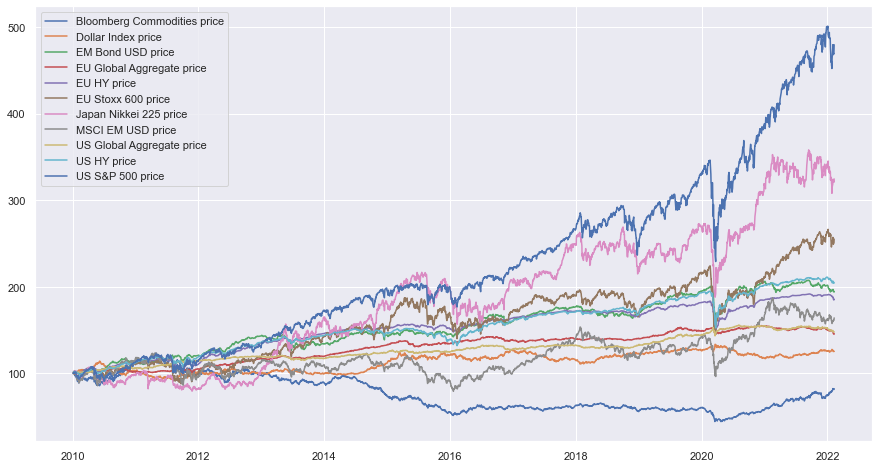

In [12]:
plt.plot(df)
plt.legend(df.columns,loc='upper left')

In [13]:
df['Strategy price']= 100 * (1 + strategy_returns['Last Price']).cumprod()

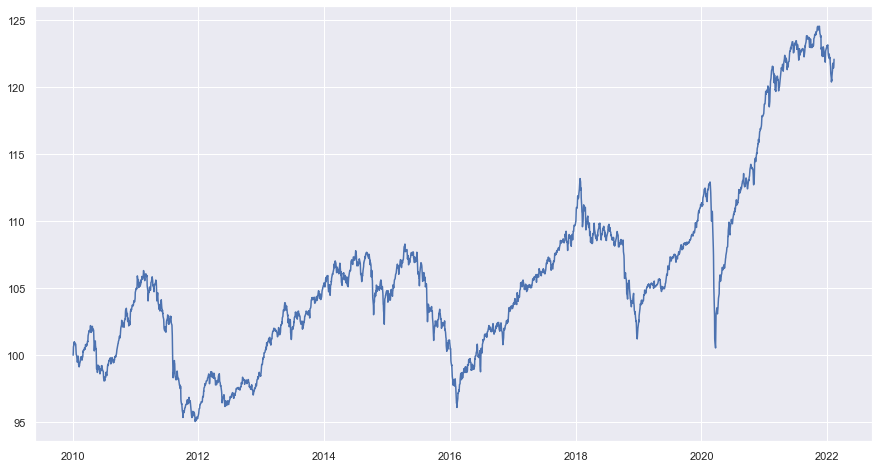

In [14]:
plt.plot(df['Strategy price'])

# DDPG

In [15]:
import sys
import copy
import matplotlib.pyplot as plt
from itertools import count
from datetime import datetime
from envmkt import Decode_v1
from ddpg import DDPGagent
from utils import *

C:\Users\duzen\anaconda3\envs\torch_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
env = Decode_v1(factors_returns=factors_returns,strategy_returns=strategy_returns,random_start=False,window=7)

In [17]:
agent = DDPGagent(env)
noise = OUNoise(env.action_space)
batch_size = 128
nb_episodes = 50

In [18]:
rewards = []
avg_rewards = []
best_env = env
best_reward = -100

for episode in range(nb_episodes):
    state = env.reset()
    noise.reset()
    episode_reward = 0
    
    for step in count():
        action = agent.get_action(state)
        action = noise.get_action(action, step)
        if step % 500 ==0:
            print(action)
            print(np.linalg.norm(action))
        new_state, reward, done, _ = env.step(action) 
        agent.memory.push(state, action, reward, new_state, done)
        
        if len(agent.memory) > batch_size:
            agent.update(batch_size)        
        
        state = new_state 
        episode_reward += reward 

        if done:
            sys.stdout.write("episode: {}, reward: {}, average _reward: {} \n".format(episode, np.round(episode_reward, decimals=2), np.mean(rewards[-10:])))
            print(f'Env reward is {freward_teacher(env.weights_df)}')
            if freward_teacher(env.weights_df) > best_reward :
                best_env = copy.deepcopy(env)
                best_reward = freward_teacher(env.weights_df)
                print(f'best reward has been set to {best_reward}')
                print('\x1b[6;30;42m' + 'best_env has been changed' + '\x1b[0m')
            break

    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards))

[ 0.03755665  0.00202981  0.01206717 -0.00234128 -0.01237273 -0.02707718
  0.04631889 -0.07089104  0.02912209 -0.11485282  0.03932343]
0.15877202414439606
[ 0.02367527  0.04893815  0.03639977  0.11182949 -0.03454642  0.00297628
 -0.01114427 -0.05192941 -0.011173   -0.22658941  0.09804804]
0.2861650347356868
[-0.03768631  0.00765914  0.09011237  0.04144942 -0.07147964 -0.08301663
  0.05621961  0.00177557 -0.04211566 -0.03608008 -0.0195614 ]
0.17303254220375552
[ 0.01885735 -0.04763858  0.03931689  0.12440271  0.08623896  0.13963771
  0.06692287  0.01015307  0.13020666 -0.09813749  0.04447554]
0.282360237986805
[-0.01558184  0.04532066 -0.01571006  0.00405943 -0.02273572 -0.08680203
  0.05871061 -0.05803879  0.01219729 -0.03550419  0.07682105]
0.15728248011457072
[-0.03480544  0.04096673  0.01183837 -0.03129624  0.00320296 -0.04611487
 -0.00656349 -0.01960926 -0.00237896 -0.03148277  0.08186042]
0.1194641743876502
[-0.02004665  0.00672263  0.0312033  -0.01871861  0.00753761 -0.05798738
 

C:\Users\duzen\anaconda3\envs\torch_env\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\duzen\anaconda3\envs\torch_env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


episode: 0, reward: -8.97, average _reward: nan 
Env reward is -0.040791567654379905
best reward has been set to -0.040791567654379905
best_env has been changed
[-0.02982455  0.01459189  0.0397637  -0.02778269  0.00792874 -0.05306892
 -0.03980094  0.03590368  0.00213592 -0.04484656  0.06570255]
0.12466122960234748
[ 0.00262876  0.00123544  0.04383616 -0.05033553  0.03994461 -0.03925337
  0.01146987  0.02971392  0.01695154 -0.02832232  0.04337622]
0.10763637652205206
[ 0.02466916 -0.02337421  0.05764343 -0.05646268  0.04661473  0.00075226
  0.00207758  0.07174063  0.01639826 -0.01086317  0.0363223 ]
0.12921483984022508
[-0.00774288 -0.02067898  0.04581318 -0.0355736   0.03103097 -0.01071673
  0.02860698  0.01832681 -0.0119372   0.01246843  0.08416267]
0.11603971304559552
[-0.01208566  0.01140831  0.05562842 -0.04851154  0.05917335 -0.03621261
  0.00918061  0.02044042  0.0286579  -0.00657298  0.07632552]
0.13315066876515078
[-0.00129832  0.03313305  0.0510725  -0.05561006  0.04453992 -0.

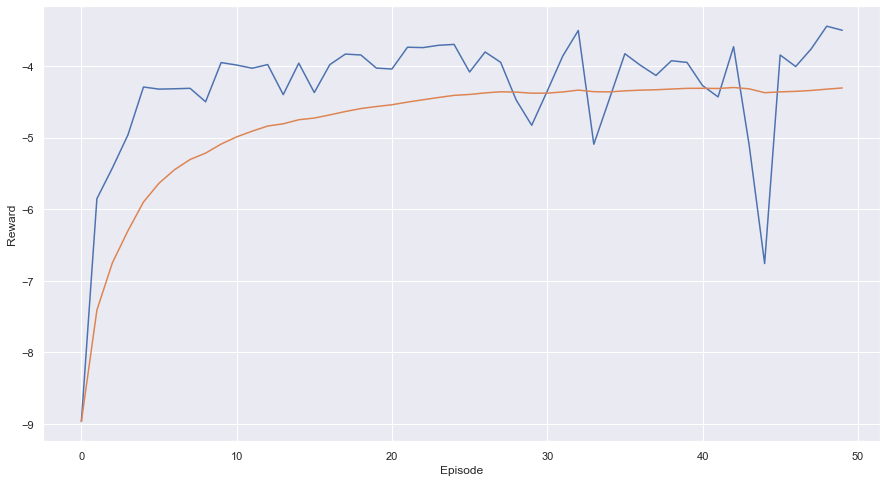

In [19]:
plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [20]:
weights_predicted = best_env.weights_df 

In [21]:
freward_teacher(weights_predicted)

-0.0214791484770339

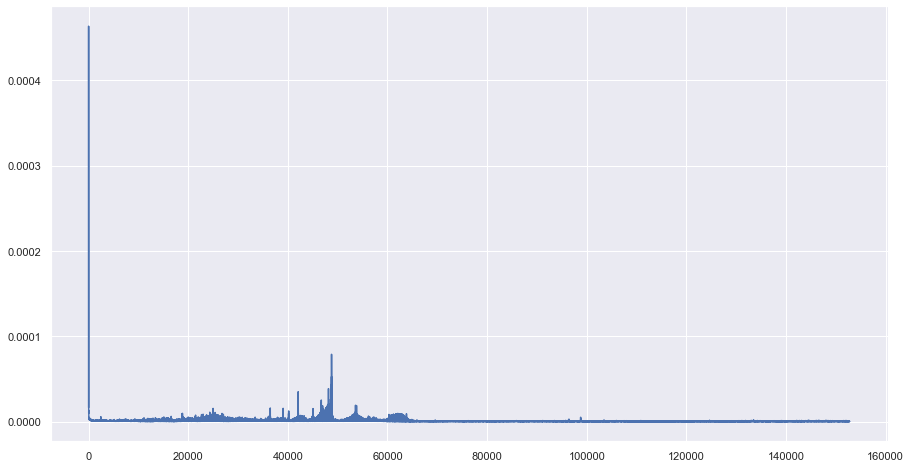

In [22]:
plt.plot(range(len(agent.critic_losses)),agent.critic_losses)
plt.show()

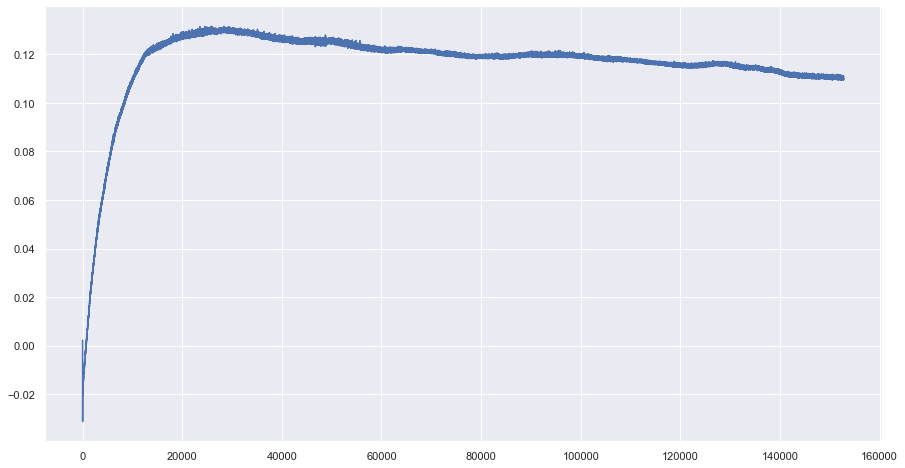

In [23]:
plt.plot(range(len(agent.actor_losses)),agent.actor_losses)
plt.show()

In [24]:
weights_predicted.head(20)

,Bloomberg Commodities,Dollar Index,EM Bond USD,EU Global Aggregate,EU HY,EU Stoxx 600,Japan Nikkei 225,MSCI EM USD,US Global Aggregate,US HY,US S&P 500
Date,,,,,,,,,,,
2010-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-05,0.072365,0.007735,0.061896,0.076174,-0.000116,0.082728,0.025099,-0.010675,0.065797,0.067097,0.072172
2010-01-06,0.072855,0.009932,0.061839,0.07237,-0.002807,0.079691,0.023127,-0.013567,0.062741,0.069505,0.070847
2010-01-07,0.077478,0.010176,0.059812,0.073675,-0.003927,0.083437,0.025085,-0.019908,0.059586,0.072693,0.072302
2010-01-08,0.076549,0.014291,0.062293,0.078063,-0.004697,0.078544,0.026694,-0.01652,0.062727,0.068436,0.072475
2010-01-11,0.078555,0.015941,0.060655,0.077553,-0.004769,0.075808,0.024846,-0.017438,0.066863,0.068226,0.074662
2010-01-12,0.075142,0.013703,0.061589,0.077584,-0.004687,0.083239,0.025853,-0.016415,0.066494,0.070289,0.073918
2010-01-13,0.076818,0.013223,0.058494,0.073187,-0.000292,0.080155,0.026086,-0.012197,0.068303,0.072509,0.073577
2010-01-14,0.074853,0.012846,0.055326,0.076831,0.006195,0.081711,0.026989,-0.013614,0.068693,0.073511,0.071657


In [25]:
pred_returns = pd.DataFrame()
pred_returns['Last Price'] = (1 + (weights_predicted * factors_returns).sum(axis=1)).cumprod().pct_change().fillna(0)

In [26]:
pred_returns.head()

,Last Price
Date,
2010-01-04,0.000000
2010-01-05,0.000844
2010-01-06,0.002102
2010-01-07,-0.000453
2010-01-08,0.000881


In [27]:
df['Agent price']= 100 * (1 + pred_returns['Last Price']).cumprod()

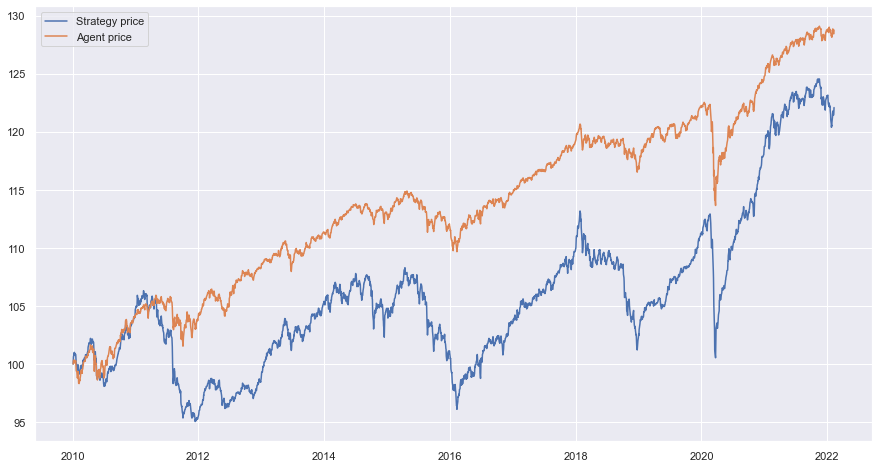

In [28]:
plt.plot(df[['Strategy price','Agent price']])
plt.legend(df[['Strategy price','Agent price']].columns,loc='upper left')

In [29]:
def create_submission(weights, factors_returns):
    # some financial computations
    weight_abs_diff = (weights - weights.shift(1)).abs().fillna(0)
    weight_abs_diff*= 0.0025 * 365 / ((weights.index[-1] - weights.index[0]).days) * np.sqrt(
        weights.shape[0] * (weights.shape[1]+1))
    pred_returns = (1 + (weights * factors_returns).sum(axis=1)).cumprod(
        ).pct_change().fillna(0)
    pred_returns*= np.sqrt(250) * np.sqrt(weights.shape[1]+1)
                    
    # format submission
    submission = pred_returns.to_frame() 
    submission.columns = ['Expected']
    submission.index = ['{:%Y-%m-%d}'.format(x) + '_returns' for x in pred_returns.index]
    
    for col in weight_abs_diff.columns:
        tmp = weight_abs_diff[col].to_frame()
        tmp.columns = ['Expected']
        tmp.index = [ '{:%Y-%m-%d}'.format(x) + '_{:}'.format(col) for x in tmp.index]
        submission = pd.concat([submission, tmp], axis=0)
    submission.index.names = ['Id']
    return submission
                    

In [30]:
submission = create_submission(best_env.weights_df , factors_returns)

In [31]:
submission.to_csv('submission.csv')